In [57]:
%matplotlib inline
from matplotlib import style
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from sqlalchemy import text
import datetime
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [58]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [59]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'measurements', 'station', 'stations']

In [60]:
start_date = datetime.date(2019, 1, 4)
end_date = datetime.date(2019, 1, 18)


In [61]:
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [62]:
session = Session(engine)


No handles with labels found to put in legend.


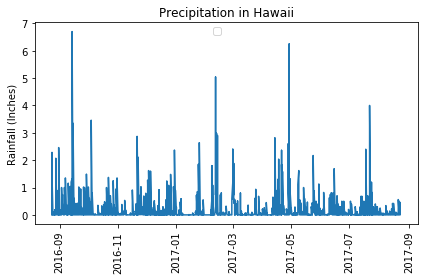

<Figure size 432x288 with 0 Axes>

In [63]:
recent_date = session.query(Measurements).order_by(Measurements.date.desc()).limit(1)
    
for date in recent_date:
    most_recent_date = date.date

most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")

one_year_ago = most_recent_date - dt.timedelta(days=365)

recent_prcp_data = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date >= one_year_ago).\
    order_by(Measurements.date).all()

df = pd.DataFrame(recent_prcp_data).dropna()


df['date'] = pd.to_datetime(df['date'])


plt.plot(df['date'], df['prcp'])
plt.title("Precipitation in Hawaii")

plt.ylabel('Rainfall (Inches)')
plt.legend(bbox_to_anchor=(0.5, 1.00))

plt.xticks(rotation='90')

plt.tight_layout()
plt.show()

plt.savefig("Images/Precipitation.png")

In [64]:
df.describe()

,prcp
count,2223.000000
mean,0.159951
std,0.441220
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


In [65]:
stations = session.query(Measurements.station).distinct().count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [66]:
num_of_stations = session.query(Stations.id).distinct().count()
num_of_stations

9

In [67]:
station_counts = session.query(Stations.station, func.count(Measurements.id)).select_from(Measurements).\
    join(Stations, Measurements.station == Stations.station).group_by(Stations.station).\
    order_by(func.count(Measurements.id).desc()).all()

for result in station_counts:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


In [68]:
most_active_station = 'USC00519281'
summary_temps = session.query(func.min(Measurements.tobs), func.max(Measurements.tobs), func.avg(Measurements.tobs)).\
    filter(Measurements.station == most_active_station).all()
print(f"Lowest Temperature: {summary_temps[0][0]} Fahrenheit")
print(f"Highest Temperature: {summary_temps[0][1]} Fahrenheit")
print(f"Average Temperature: {round(summary_temps[0][2], 2)} Fahrenheit")

Lowest Temperature: 54.0 Fahrenheit
Highest Temperature: 85.0 Fahrenheit
Average Temperature: 71.66 Fahrenheit


In [69]:
yearly_temps = session.query(Measurements.date, Measurements.tobs).filter(Measurements.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", Measurements.date) >= datetime.date(2016, 8, 23)).all()

#save as a data frame
yearly_temps_df = pd.DataFrame(yearly_temps, columns = ['date', 'temperature'])
yearly_temps_df.head()

,date,temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


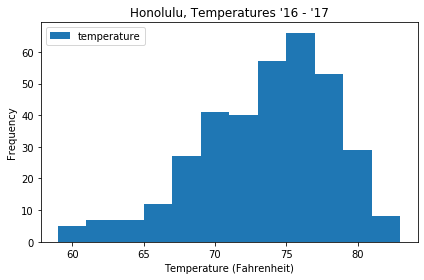

In [70]:
yearly_temps_df.set_index('date', inplace = True)
fig, ax = plt.subplots()
yearly_temps_df.plot.hist(bins = 12, ax = ax)

#set labels
ax.set_xlabel('Temperature (Fahrenheit)')
ax.set_ylabel('Frequency')
ax.set_title("Honolulu, Temperatures '16 - '17")

#save figure
plt.savefig("Images/temphist.png")

#plot
plt.tight_layout()
plt.show()

In [71]:
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
print(calc_temps('2016-02-28', '2016-03-05'))

[(62.0, 69.88636363636364, 80.0)]


In [72]:
temps = calc_temps('2017-01-01', '2017-01-10')
temps

[(60.0, 68.0327868852459, 77.0)]

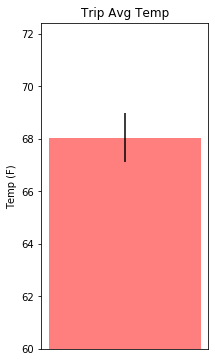

In [74]:
lower = temps[0][1] - temps[0][0]
upper = temps[0][2] - temps[0][1]

plt.figure(figsize=(3,6))
plt.bar(0, temps[0][1], yerr=[upper-lower], color='red', alpha=0.5)
plt.title('Trip Avg Temp')
plt.xticks([])
plt.ylabel('Temp (F)')
plt.ylim(60)

plt.show()

In [76]:
yearly_rainfall = session.query(Stations.station, Stations.name, Stations.latitude, Stations.longitude,
                               Stations.elevation, func.avg(Measurements.prcp)).\
    filter(Measurements.station == Stations.station).\
    filter(func.strftime("%Y-%m-%d", Measurements.date) >= datetime.date(2016, 8, 23)).group_by(Stations.station).\
    order_by(func.avg(Measurements.prcp).desc()).all()

yearly_rainfall_df = pd.DataFrame(yearly_rainfall, columns = ['Station', 'Name', 'Latitude', 'Longitude', 
                                                              'Elevation', 'Avg. Precipitation (in.)'])

yearly_rainfall_df

,Station,Name,Latitude,Longitude,Elevation,Avg. Precipitation (in.)
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.423524
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.198949
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.141429
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.112789
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.108984
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044571
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.025082


In [78]:
def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurements.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [79]:
trip_dates = ["01-04", "01-05", "01-06", "01-07", "01-08", "01-09", "01-10", "01-11", "01-12", "01-13", "01-14",
             "01-15", "01-16", "01-17", "01-18"]

In [80]:
daily_norms = []

for trip_date in trip_dates:
    day = {}
    day['Date'] = f"2019-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['Min'] = daily_norm[0][0]
    day['Avg'] = daily_norm[0][1]
    day['Max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms

[{'Date': '2019-01-04', 'Min': 58.0, 'Avg': 70.0, 'Max': 76.0},
 {'Date': '2019-01-05', 'Min': 56.0, 'Avg': 67.96428571428571, 'Max': 76.0},
 {'Date': '2019-01-06', 'Min': 61.0, 'Avg': 68.96491228070175, 'Max': 76.0},
 {'Date': '2019-01-07', 'Min': 57.0, 'Avg': 68.54385964912281, 'Max': 76.0},
 {'Date': '2019-01-08', 'Min': 57.0, 'Avg': 67.16071428571429, 'Max': 75.0},
 {'Date': '2019-01-09', 'Min': 58.0, 'Avg': 67.9298245614035, 'Max': 78.0},
 {'Date': '2019-01-10', 'Min': 62.0, 'Avg': 69.74137931034483, 'Max': 77.0},
 {'Date': '2019-01-11', 'Min': 57.0, 'Avg': 67.3103448275862, 'Max': 78.0},
 {'Date': '2019-01-12', 'Min': 57.0, 'Avg': 67.4074074074074, 'Max': 81.0},
 {'Date': '2019-01-13', 'Min': 57.0, 'Avg': 67.25454545454545, 'Max': 77.0},
 {'Date': '2019-01-14', 'Min': 58.0, 'Avg': 69.52631578947368, 'Max': 77.0},
 {'Date': '2019-01-15', 'Min': 56.0, 'Avg': 69.31372549019608, 'Max': 78.0},
 {'Date': '2019-01-16', 'Min': 54.0, 'Avg': 68.62962962962963, 'Max': 80.0},
 {'Date': '2019

In [81]:
daily_norms_df = pd.DataFrame(daily_norms)
daily_norms_df.set_index('Date', inplace = True)

daily_norms_df

,Min,Avg,Max
Date,,,
2019-01-04,58.0,70.000000,76.0
2019-01-05,56.0,67.964286,76.0
2019-01-06,61.0,68.964912,76.0
2019-01-07,57.0,68.543860,76.0
2019-01-08,57.0,67.160714,75.0
2019-01-09,58.0,67.929825,78.0
2019-01-10,62.0,69.741379,77.0
2019-01-11,57.0,67.310345,78.0
2019-01-12,57.0,67.407407,81.0


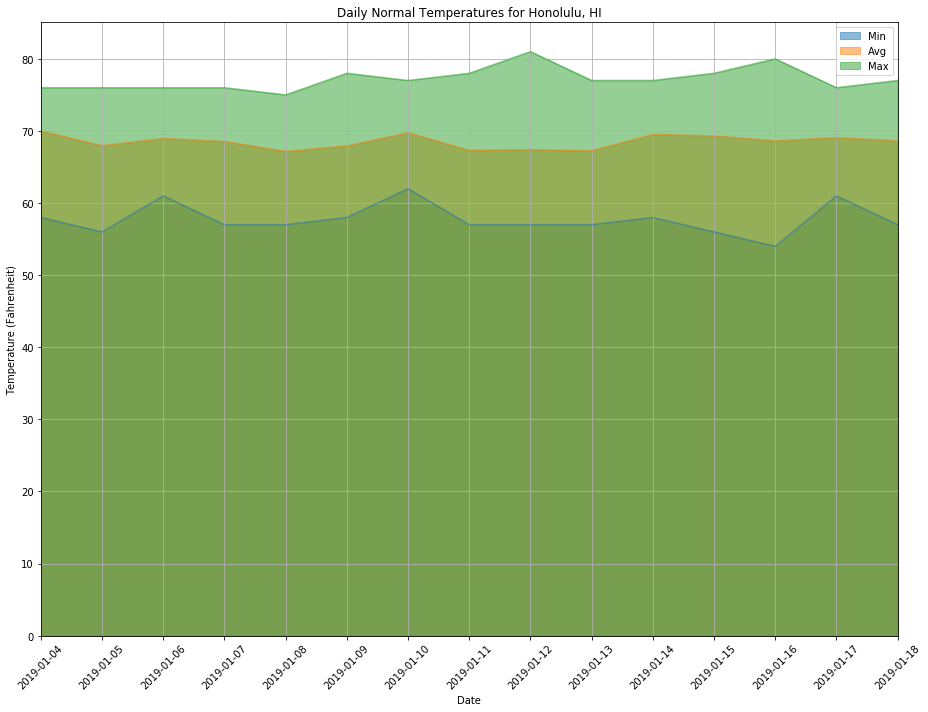

In [82]:
fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, HI')

dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

plt.savefig('Images/dailynormarea.png')

plt.grid()
plt.tight_layout()
plt.show()
